In [81]:
#Import librares and functions
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from pathlib import Path
import random
import engine
from torchvision import transforms
import ssl
import shutil
from torch.utils.data import random_split
device='cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
current_directory = Path.cwd()
data_dir=current_directory/'Data'
ssl._create_default_https_context = ssl._create_unverified_context
#Create transform
vit_transforms=ViT_B_16_Weights.DEFAULT.transforms()
#Create dataset using Food101 dataset
train_data=torchvision.datasets.Food101(root=data_dir,
                             split='train',
                             transform=vit_transforms,
                             download=True)

test_data=torchvision.datasets.Food101(root=data_dir,
                             split='test',
                             transform=vit_transforms,
                             download=True)
class_names=train_data.classes

In [83]:
#Split dataset
seed=42
def split_dataset(dataset:torchvision.datasets,
                 split_size:float=0.2,
                 seed:int=12):
    dataset_len=int(len(dataset))
    len_1=int(split_size*dataset_len)
    random_split_1, random_split_2=random_split(dataset,
                   [len_1, dataset_len-len_1],
                  generator=torch.manual_seed(seed))
    return random_split_1, random_split_2
train_data_food101_15_percent,_=split_dataset(dataset=train_data,split_size=0.25,seed=seed)
test_data_food101_15_percent,_=split_dataset(dataset=test_data,split_size=0.25,seed=seed)

In [84]:
#Create dataloaders
from torch.utils.data import DataLoader
NUM_WORKERS=1
BATCH_SIZE=16
train_dataloader=DataLoader(train_data_food101_15_percent,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS)
test_dataloader=DataLoader(train_data_food101_15_percent,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=NUM_WORKERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


Text(0.5, 1.0, 'samosa')

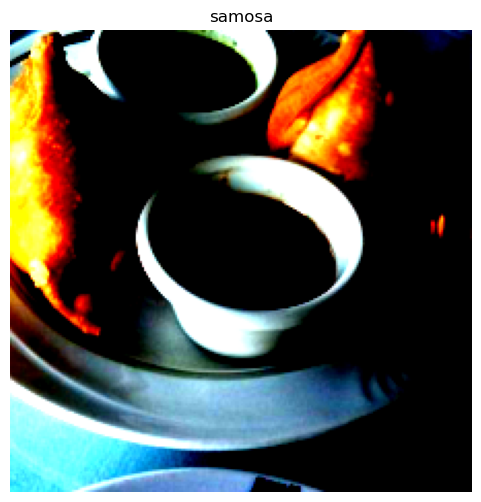

In [85]:
#Plot example image with class name
image, image_label =next(iter(train_dataloader))
image=image[0]
image_label=image_label[0]
print(image.shape)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(image.permute(1,2,0))
plt.title(class_names[image_label])

In [86]:
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights

pretrained_vit=vit_b_16(weights=ViT_B_16_Weights).to(device)

In [87]:
for i,layer in enumerate(pretrained_vit.children()):
  if i <2:
    for param in layer.parameters():
      param.requires_grad=False

In [88]:
summary(pretrained_vit,
        input_size=(1,3, 224, 224),
        col_names=["trainable","output_size","num_params",])

Layer (type:depth-idx)                        Trainable                 Output Shape              Param #
VisionTransformer                             Partial                   [1, 1000]                 768
├─Conv2d: 1-1                                 False                     [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                False                     [1, 197, 768]             151,296
│    └─Dropout: 2-1                           --                        [1, 197, 768]             --
│    └─Sequential: 2-2                        False                     [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 

In [89]:
pretrained_vit.heads=nn.Linear(in_features=768,out_features=101)
summary(pretrained_vit,
        input_size=(1,3, 224, 224),
        col_names=["trainable","output_size","num_params",'input_size'])

Layer (type:depth-idx)                        Trainable                 Output Shape              Param #                   Input Shape
VisionTransformer                             Partial                   [1, 101]                  768                       [1, 3, 224, 224]
├─Conv2d: 1-1                                 False                     [1, 768, 14, 14]          (590,592)                 [1, 3, 224, 224]
├─Encoder: 1-2                                False                     [1, 197, 768]             151,296                   [1, 197, 768]
│    └─Dropout: 2-1                           --                        [1, 197, 768]             --                        [1, 197, 768]
│    └─Sequential: 2-2                        False                     [1, 197, 768]             --                        [1, 197, 768]
│    │    └─EncoderBlock: 3-1                 False                     [1, 197, 768]             (7,087,872)               [1, 197, 768]
│    │    └─EncoderBlock: 3-2 

In [90]:
summary(pretrained_vit,
        input_size=(1,3, 224, 224),
        col_names=["trainable","output_size","num_params",])

Layer (type:depth-idx)                        Trainable                 Output Shape              Param #
VisionTransformer                             Partial                   [1, 101]                  768
├─Conv2d: 1-1                                 False                     [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                False                     [1, 197, 768]             151,296
│    └─Dropout: 2-1                           --                        [1, 197, 768]             --
│    └─Sequential: 2-2                        False                     [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 False                     [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 

In [91]:
#Set optimizer and loss function
optimizer=torch.optim.Adam(lr=0.0002,params=pretrained_vit.parameters(),weight_decay=0.1)
loss_fn=nn.CrossEntropyLoss()

In [26]:
# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5424 | train_acc: 0.5175 | test_loss: 2.4548 | test_acc: 0.5477
Epoch: 2 | train_loss: 2.4972 | train_acc: 0.5302 | test_loss: 2.4402 | test_acc: 0.5607
Epoch: 3 | train_loss: 2.4908 | train_acc: 0.5327 | test_loss: 2.4414 | test_acc: 0.5541
Epoch: 4 | train_loss: 2.4913 | train_acc: 0.5296 | test_loss: 2.4369 | test_acc: 0.5527
Epoch: 5 | train_loss: 2.4900 | train_acc: 0.5320 | test_loss: 2.4394 | test_acc: 0.5526


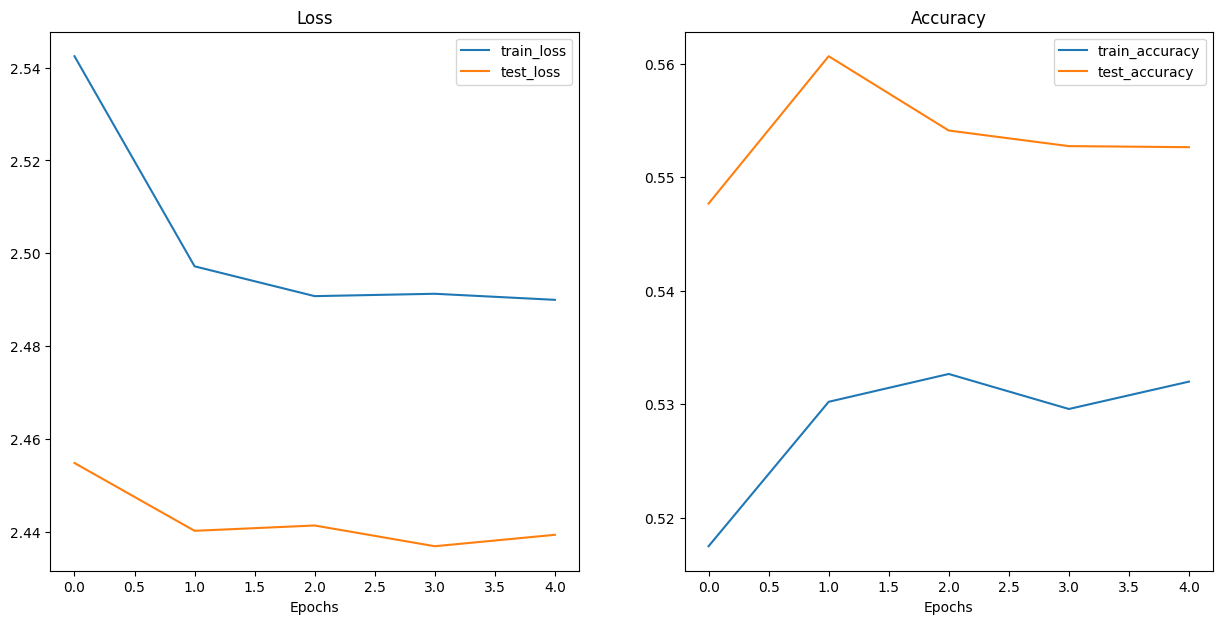

In [27]:
loss = pretrained_vit_results["train_loss"]
test_loss = pretrained_vit_results["test_loss"]
accuracy = pretrained_vit_results["train_acc"]
test_accuracy = pretrained_vit_results["test_acc"]

epochs = range(len(pretrained_vit_results["train_loss"]))

plt.figure(figsize=(15, 7))

    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [92]:
current_directory = Path.cwd()
target_dir_path = Path.cwd()/'Models'
model_name='ViT_bipo12.pth'
model_save_path = current_directory/target_dir_path / model_name
target_dir_path.mkdir(parents=True,
                     exist_ok=True)

In [93]:
torch.save(pretrained_vit.state_dict(), model_save_path)

In [94]:
ViT_loaded=pretrained_vit
ViT_loaded.load_state_dict(torch.load(model_save_path))
ViT_loaded.to("cpu")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [95]:
# Create folder for Gradio App
foodclassifier_path = current_directory/Path("Demos/foodclassifier/")
foodclassifier_path.mkdir(parents=True, exist_ok=True)

In [96]:
#Create examples image
(foodclassifier_path / "examples").mkdir(parents=True, exist_ok=True)
test_data_paths = list(data_dir.glob("*/*/*/*.jpg"))
random.seed(seed)
example_list = [filepath for filepath in random.sample(test_data_paths, k=3)]
for example in example_list:
    destination = foodclassifier_path / "examples" / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Data\food-101\images\red_velvet_cake\372523.jpg to C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Demos\foodclassifier\examples\372523.jpg
[INFO] Copying C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Data\food-101\images\carrot_cake\31925.jpg to C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Demos\foodclassifier\examples\31925.jpg
[INFO] Copying C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Data\food-101\images\beef_carpaccio\1864287.jpg to C:\Users\bipo12\Desktop\DL_Engineer\Git\Food_classifier\Demos\foodclassifier\examples\1864287.jpg


In [97]:
#Create class names file
with open(foodclassifier_path / "class_names.txt",'w') as f:
    f.write("\n".join(class_names))


In [98]:
#Copy model
shutil.copy2(src=model_save_path, dst=foodclassifier_path)

'C:\\Users\\bipo12\\Desktop\\DL_Engineer\\Git\\Food_classifier\\Demos\\foodclassifier\\ViT_bipo12.pth'

In [99]:
%%writefile Demos/foodclassifier/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.50.2

Overwriting Demos/foodclassifier/requirements.txt


In [100]:
%%writefile Demos/foodclassifier/model.py
#Create file with model creation function
import torch
import torchvision
from torch import nn
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights

def create_pretrained_vit():
    model=vit_b_16(weights=ViT_B_16_Weights)
    transforms=ViT_B_16_Weights.DEFAULT.transforms()
    for i,layer in enumerate(model.children()):
      if i <2:
        for param in layer.parameters():
          param.requires_grad=False
    model.heads=nn.Linear(in_features=768,out_features=101)

    return model, transforms

Overwriting Demos/foodclassifier/model.py


In [101]:
%%writefile Demos/foodclassifier/app.py
import gradio as gr
import os
import torch
from model import create_pretrained_vit
from timeit import default_timer as timer

# Setup class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in  f.readlines()]
# Create model
model, transforms = create_pretrained_vit()

# Load saved weights
model.load_state_dict(
    torch.load(
        f="ViT_bipo12.pth",
        map_location=torch.device("cpu")))

# Create predict function
def predict(img):
    img = transforms(img).unsqueeze(0)

    start_time = timer()

    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time


# Create title, description and article strings
title = "Food classification using transformers for image recognition"
description = "ML model based on publication Alexey Dosovitskiy et. al.'An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale'"
article = ""

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Overwriting Demos/foodclassifier/app.py
